Note: For analyzing trends and general properties, there is no need to separate the training set from the dev set and test set. Therefore all three dataframes are concatenated together.

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import json
from matplotlib.dates import DateFormatter
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12

In [2]:
# Load all three dataframes, and concatenate them together.
df_train = pd.read_csv('../assets/df_train_full_info.csv')
df_dev = pd.read_csv('../assets/df_dev_full_info.csv')
df_test = pd.read_csv('../assets/df_test_full_info.csv')
df = pd.concat([df_train,df_dev,df_test])
df['created_at'] = pd.to_datetime(df['created_at'])

In [3]:
# Take a look at all the disasters.
df.groupby(by=['place','disaster','year']).agg({'id':'count'}).rename(columns={'id':'Tweet Count'}).reset_index()

,place,disaster,year,Tweet Count
0,california,wildfires,2018,4617
1,canada,wildfires,2016,1474
2,dorian(us+caribbean+bamahas),hurricane,2019,5290
3,ecuador,earthquake,2016,981
4,florence(us+cape_verde+bermuda),hurricane,2018,4388
5,harvey(us+caribbean+latin_america),hurricane,2017,6122
6,idai(Africa),cyclone,2019,3061
7,irma(us+caribbean),hurricane,2017,6368
8,italy,earthquake,2016,728
9,kaikoura(new_zealand),earthquake,2016,1443


In [4]:
# Let's first focus on Hurricane Harvey. It has the most tweets, and it's in the largest disaster category (hurricane).
# Focus first on the subset where this tweet can still be retrieved successfully by Apr 24, 2021.
df_harvey = df[df['place'].str.startswith('harvey')]
df_harvey_successful = df_harvey[df_harvey['Response-Code']=='Successful']

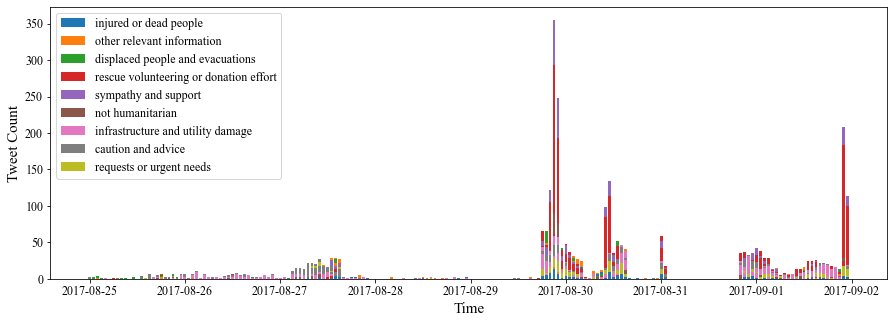

In [5]:
# Trends of Harvey-related tweets.
df_harvey_successful_reset_index = df_harvey_successful.set_index('created_at')
df_agg = df_harvey_successful_reset_index.groupby(pd.Grouper(freq='H')).agg({'id_str':'count'}).rename(columns={'id_str':'Tweet Count'})
class_list = df_harvey_successful['class_label'].unique()
figure,ax = plt.subplots(figsize=(15,5))
agg_class_past = [0]*df_agg.shape[0]
for class_label in class_list:
    df_class = df_harvey_successful_reset_index[df_harvey_successful_reset_index['class_label']==class_label]
    df_class_agg = df_class.groupby(pd.Grouper(freq='H')).agg({'id_str':'count'}).rename(columns={'id_str':'Tweet Class Count'})
    df_class_agg = pd.merge(df_agg,df_class_agg,how='left',left_index=True,right_index=True).fillna(0)
    ax.bar(df_class_agg.index, df_class_agg['Tweet Class Count'], width=0.03, bottom=agg_class_past,label=class_label.replace('_',' '))
    agg_class_past=df_class_agg['Tweet Class Count']
ax.set_xlabel('Time',fontsize=15)
ax.set_ylabel('Tweet Count',fontsize=15)
plt.legend()

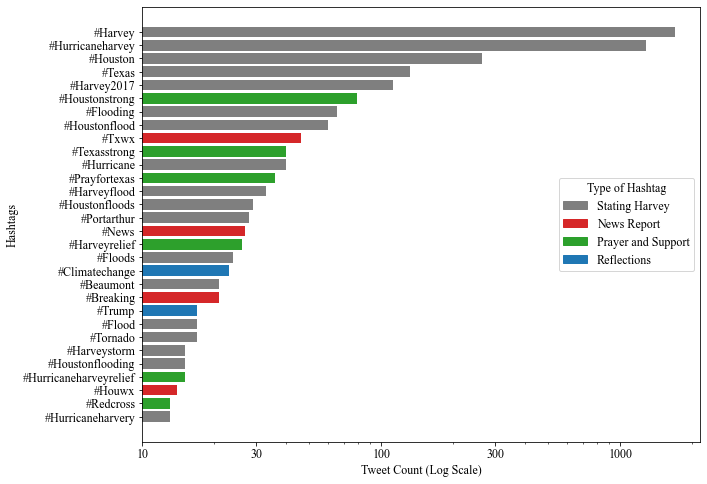

In [25]:
# What are the hottest topics those tweeters care about?
# We will observe the use of hashtags here. Some patterns can be easily observed from the visualization...
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
df_harvey_successful_reset_index['hashtags'] = df_harvey_successful_reset_index['entities'].map(lambda x:eval(x)['hashtags'])
df_hashtag_harvey = df_harvey_successful_reset_index.explode('hashtags').dropna(subset=['hashtags'])
df_hashtag_harvey['hashtags'] = df_hashtag_harvey['hashtags'].map(lambda x:x['text'][0].upper()+x['text'].lower()[1:])
df_hashtag_harvey_agg = df_hashtag_harvey.groupby(by='hashtags').agg({'id_str':'count'}).rename(columns={'id_str':'Tweet Count'})
df_hashtag_harvey_agg = df_hashtag_harvey_agg.sort_values(by='Tweet Count',ascending=False).head(30)

# Decide the "types" of hashtag (hard-coded)
label = np.zeros(30,)
type_prayer_and_support=[5,9,11,16,26,28]
type_news=[8,15,20,27]
type_reflections=[18,21]
for i in type_prayer_and_support:
    label[i]=0.25
for i in type_news:
    label[i]=0.5
for i in type_reflections:
    label[i]=1


clist = [(0, "#7f7f7f"),  (0.25, "#2ca02c"),(0.5,"#d62728"),(1,"#1f77b4")]
rvb = mcolors.LinearSegmentedColormap.from_list("", clist)
import matplotlib.ticker as ticker
fig,ax = plt.subplots(figsize=(10,8))
ax.barh(['#'+i for i in df_hashtag_harvey_agg.index[::-1]],df_hashtag_harvey_agg['Tweet Count'][::-1],color=rvb(label[::-1]))
ax.set_xscale('log')
ax.set_ylabel('Hashtags')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax.set_xticks([10,30,100,300,1000])
ax.set_xlabel('Tweet Count (Log Scale)')
red_patch = mpatches.Patch(color='#d62728', label='News Report')
gray_patch = mpatches.Patch(color='#7f7f7f', label='Stating Harvey')
green_patch = mpatches.Patch(color='#2ca02c', label='Prayer and Support')
blue_patch = mpatches.Patch(color="#1f77b4", label='Reflections')
plt.legend(handles=[gray_patch,red_patch,green_patch,blue_patch],title='Type of Hashtag',loc='right')

In [33]:
# We will see how the number of each "type" of tweets (except for "Stating Harvey") changes with time.
list_hashtag = [i.lower() for i in list(df_hashtag_harvey_agg.index)]
list_hashtag_prayer_support = [list_hashtag[i] for i in type_prayer_and_support]
list_hashtag_reflections = [list_hashtag[i] for i in type_reflections]
list_hashtag_news = [list_hashtag[i] for i in type_news]
df_harvey_successful_reset_index['hashtags'] = df_harvey_successful_reset_index['hashtags'].map(lambda x:[i['text'].lower() for i in x])

df=df_harvey_successful_reset_index.copy()

def contain(x,lists):
    return bool(set(x).intersection(set(lists)))

df['prayer_support'] = df['hashtags'].apply(lambda x:contain(x,list_hashtag_prayer_support))
df['news'] = df['hashtags'].apply(lambda x:contain(x,list_hashtag_news))
df['reflections'] = df['hashtags'].apply(lambda x:contain(x,list_hashtag_reflections))

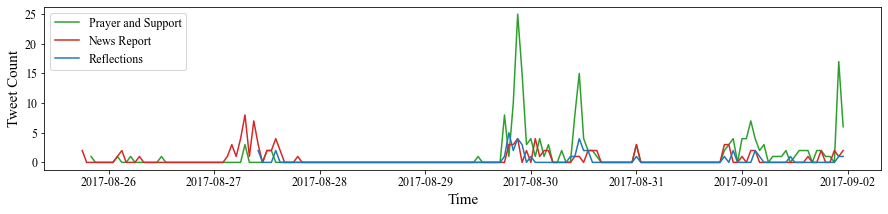

In [41]:
fig,ax=plt.subplots(figsize=(15,3))
df_prayer = df[df['prayer_support']==True].groupby(pd.Grouper(freq='H')).agg({'id_str':'count'}).rename(columns={'id_str':'Tweet Count'})
df_news = df[df['news']==True].groupby(pd.Grouper(freq='H')).agg({'id_str':'count'}).rename(columns={'id_str':'Tweet Count'})
df_reflections = df[df['reflections']==True].groupby(pd.Grouper(freq='H')).agg({'id_str':'count'}).rename(columns={'id_str':'Tweet Count'})

ax.plot(df_prayer.index,df_prayer['Tweet Count'],label='Prayer and Support',color="#2ca02c")
ax.plot(df_news.index,df_news['Tweet Count'],label='News Report',color="#d62728")
ax.plot(df_reflections.index,df_reflections['Tweet Count'],label='Reflections',color="#1f77b4")
ax.set_xlabel('Time',fontsize=15)
ax.set_ylabel('Tweet Count',fontsize=15)
plt.legend()

In [36]:
# What exactly happened around those moments where peaked?

,Tweet Class Count
created_at,
2017-08-25 18:00:00+00:00,2
2017-08-25 19:00:00+00:00,0
2017-08-25 20:00:00+00:00,0
2017-08-25 21:00:00+00:00,0
2017-08-25 22:00:00+00:00,0
...,...
2017-09-01 19:00:00+00:00,0
2017-09-01 20:00:00+00:00,0
2017-09-01 21:00:00+00:00,2


In [ ]:
# We construct a heatmap on the confusion matrix of these tweets. Features include:
# length of tweet, properties of tweets (text difficulty, sentiment), likes & retweets.
# 

In [ ]:
# Earthquake-related tweets should be presenting another distinct pattern. 
# E.g. there should be fewer warnings considering its unpredictability.
df_kaikoura = df[df['place'].str.startswith('kaikoura')]
df_kaikoura_successful = df_kaikoura[df_kaikoura['Response-Code']=='Successful']
df_kaikoura_successful = df_kaikoura_successful[df_kaikoura_successful['created_at'].dt.month==11]
df_kaikoura_successful_reset_index = df_kaikoura_successful.set_index('created_at')
df_agg = df_kaikoura_successful_reset_index.groupby(pd.Grouper(freq='H')).agg({'id_str':'count'}).rename(columns={'id_str':'Tweet Count'})
class_list = df_kaikoura_successful['class_label'].unique()
figure,ax = plt.subplots(figsize=(15,5))
agg_class_past = [0]*df_agg.shape[0]
for class_label in class_list:
    df_class = df_kaikoura_successful_reset_index[df_kaikoura_successful_reset_index['class_label']==class_label]
    df_class_agg = df_class.groupby(pd.Grouper(freq='H')).agg({'id_str':'count'}).rename(columns={'id_str':'Tweet Class Count'})
    df_class_agg = pd.merge(df_agg,df_class_agg,how='left',left_index=True,right_index=True).fillna(0)
    ax.bar(df_class_agg.index, df_class_agg['Tweet Class Count'], width=0.03, bottom=agg_class_past,label=class_label.replace('_',' '))
    agg_class_past=df_class_agg['Tweet Class Count']
ax.set_xlabel('Time',fontsize=15)
ax.set_ylabel('Tweet Count',fontsize=15)
plt.legend()

In [ ]:
# We can see VERY different trends for hurricane-harvey and earthquake-kaikoura. 
# So, question: is there a way to compare the similarity between trends?
# Review what we learned in SIADS-622?